In [1]:
import os
import glob

In [2]:
import io
import torch
import numpy as np
from PIL import Image

In [3]:
from doctr.models import ocr_predictor, db_resnet50, vitstr_small
from doctr.models.predictor import OCRPredictor
from doctr.models.detection.predictor import DetectionPredictor
from doctr.models.recognition.predictor import RecognitionPredictor
from doctr.models.preprocessor import PreProcessor

c:\Users\chong\Desktop\Coding\Github\captcha-llm\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
parent_dir = "C:/Users/chong/Desktop/Coding/Github/captcha-llm"

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
det_model = db_resnet50(pretrained=False, pretrained_backbone=False)
det_params = torch.load(os.path.join(parent_dir, 'models/ascii-captcha/db_resnet50_20250616-122929.pt'), map_location=device)
det_model.load_state_dict(det_params)
det_model.to(device)
#det_model.eval()

reco_model = vitstr_small(pretrained=False, pretrained_backbone=False, vocab="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")
reco_params = torch.load(os.path.join(parent_dir, 'models/ascii-captcha/vitstr_small_20250617-120705.pt'), map_location=device)
reco_model.load_state_dict(reco_params)
reco_model.to(device)
#reco_model.eval()

det_predictor = DetectionPredictor(
    PreProcessor(
        (2048, 2048),
        batch_size=1,
        mean=(0.798, 0.785, 0.772),
        std=(0.264, 0.2749, 0.287),
        preserve_aspect_ratio=True
    ),
    det_model
)


reco_predictor = RecognitionPredictor(
    PreProcessor(
        (32, 128),
        preserve_aspect_ratio=True,
        batch_size=1024,
        mean=(0.694, 0.695, 0.693),
        std=(0.299, 0.296, 0.301)
    ),
    reco_model
)

predictor = OCRPredictor(det_predictor, reco_predictor)

In [7]:
predictor = ocr_predictor(pretrained=True)

In [8]:
image_dir = "data/ascii-captcha-image-doctr"
png_files = glob.glob(os.path.join(parent_dir, image_dir, "**", "*.png"), recursive=True)

if not png_files:
    raise FileNotFoundError("No PNG files found in the specified directory.")

In [15]:
import random
image_path = random.choice(png_files)
image_path = "captcha.png"

In [16]:
image = Image.open(image_path)
image = image.convert("RGB")
image = np.array(image)

results = predictor([image])
print(results)

Document(
  (pages): [Page(
    dimensions=(168, 300)
    (blocks): [Block(
      (lines): [
        Line(
          (words): [Word(value='CAPTCHA', confidence=1.0)]
        ),
        Line(
          (words): [Word(value='-', confidence=0.94)]
        ),
      ]
      (artefacts): []
    )]
  )]
)


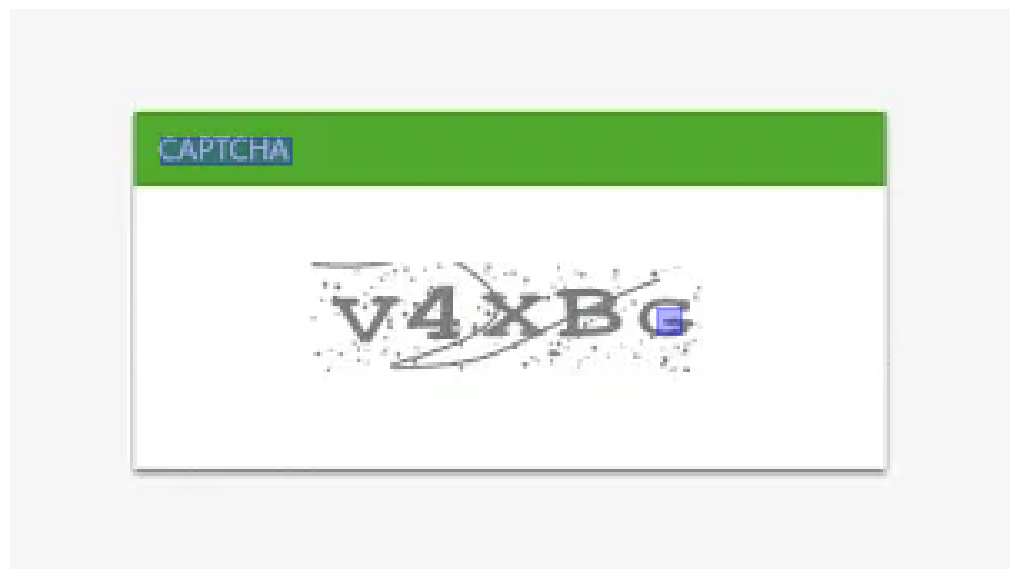

In [17]:
results.show()